In [15]:
# ============================================================================
# 1. IMPORTACIÓN DE LIBRERÍAS
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Librerías para preprocesamiento
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# Librerías para modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Librerías para evaluación
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, confusion_matrix,
                            classification_report, roc_curve, precision_recall_curve)

# Librerías para interpretabilidad
import shap

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("="*80)
print("MODELO PREDICTIVO DE DESNUTRICIÓN CRÓNICA INFANTIL - ENDES 2024")
print("="*80)

MODELO PREDICTIVO DE DESNUTRICIÓN CRÓNICA INFANTIL - ENDES 2024


In [16]:
# ============================================================================
# 2. CARGA DE DATOS
# ============================================================================

print("\n[1/8] CARGANDO DATOS...")

# Cargar archivo SPSS (.sav)
try:
    df = pd.read_spss('RECH6_2024.sav')
    print(f"✓ Datos cargados exitosamente: {df.shape[0]} registros, {df.shape[1]} variables")
except FileNotFoundError:
    print("⚠ Archivo RECH6_2024.sav no encontrado. Creando datos de ejemplo...")
    # Crear datos sintéticos para demostración
    np.random.seed(42)
    n_samples = 18000
    df = pd.DataFrame({
        'HC1': np.random.randint(0, 60, n_samples),  # Edad en meses
        'HC2': np.random.uniform(2.5, 20, n_samples),  # Peso kg
        'HC3': np.random.uniform(45, 110, n_samples),  # Talla cm
        'HC27': np.random.choice([1, 2], n_samples),  # Sexo
        'HC56A': np.random.uniform(8, 15, n_samples),  # Hemoglobina
        'HC57A': np.random.choice([1, 2, 3, 4], n_samples, p=[0.05, 0.15, 0.20, 0.60]),  # Anemia
        'HC61': np.random.choice([0, 1, 2, 3], n_samples, p=[0.10, 0.25, 0.45, 0.20]),  # Educ materna
        'HC63': np.random.uniform(12, 60, n_samples),  # Intervalo intergenésico
        'HC64': np.random.randint(1, 7, n_samples),  # Orden nacimiento
        'HC70': np.random.uniform(-400, 200, n_samples),  # Talla/Edad DE
        'HC8': np.random.uniform(-300, 200, n_samples),  # Peso/Edad DE
        'HC11': np.random.uniform(-300, 200, n_samples),  # Peso/Talla DE
        'QUINTIL': np.random.choice([1, 2, 3, 4, 5], n_samples),  # Quintil riqueza
        'AREA': np.random.choice([1, 2], n_samples, p=[0.70, 0.30]),  # Urbano/Rural
        'REGION': np.random.choice([1, 2, 3], n_samples)  # Costa/Sierra/Selva
    })
    print(f"✓ Datos sintéticos creados: {df.shape[0]} registros, {df.shape[1]} variables")

# Mostrar información básica
print("\n📊 Información del Dataset:")
print(df.info())
print("\n📈 Estadísticas Descriptivas:")
print(df.describe())


[1/8] CARGANDO DATOS...
✓ Datos cargados exitosamente: 20290 registros, 43 variables

📊 Información del Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20290 entries, 0 to 20289
Data columns (total 43 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   ID1     20290 non-null  float64 
 1   HHID    20290 non-null  object  
 2   HC0     20290 non-null  float64 
 3   HC1     20290 non-null  float64 
 4   HC2     19977 non-null  float64 
 5   HC3     19968 non-null  float64 
 6   HC4     19968 non-null  category
 7   HC5     19968 non-null  category
 8   HC6     19968 non-null  category
 9   HC7     19968 non-null  category
 10  HC8     19968 non-null  category
 11  HC9     19968 non-null  category
 12  HC10    19968 non-null  category
 13  HC11    19968 non-null  category
 14  HC12    19968 non-null  category
 15  HC13    20290 non-null  category
 16  HC15    19977 non-null  category
 17  HC16    20290 non-null  float64 
 18  HC19    2029

In [18]:
# ============================================================================
# 3. LIMPIEZA DE DATOS
# ============================================================================

print("\n[2/8] LIMPIANDO DATOS...")

# 3.1 Crear copia del dataframe
df_clean = df.copy()

# 3.2 Eliminar valores implausibles según diccionario ENDES
implausible_values = [9996, 9997, 9998, 9999, 97, 98, 99]

for col in df_clean.columns:
    for val in implausible_values:
        df_clean[col] = df_clean[col].replace(val, np.nan)

print(f"✓ Valores implausibles reemplazados por NaN")

# 3.3 Eliminar registros sin variable objetivo (HC70)
df_clean = df_clean[df_clean['HC70'].notna()]
print(f"✓ Registros después de eliminar HC70 faltantes: {df_clean.shape[0]}")

# 3.4 Verificar valores faltantes
missing_percent = (df_clean.isnull().sum() / len(df_clean)) * 100
print("\n📉 Porcentaje de valores faltantes por variable:")
print(missing_percent[missing_percent > 0].sort_values(ascending=False))

# 3.5 Eliminar columnas con >30% de valores faltantes
cols_to_drop = missing_percent[missing_percent > 30].index.tolist()
if cols_to_drop:
    df_clean = df_clean.drop(columns=cols_to_drop)
    print(f"✓ Columnas eliminadas (>30% faltantes): {cols_to_drop}")

# 3.6 Eliminar registros con muchos valores faltantes
threshold = 0.3 * df_clean.shape[1]
df_clean = df_clean[df_clean.isnull().sum(axis=1) < threshold]
print(f"✓ Registros después de eliminar filas con >30% faltantes: {df_clean.shape[0]}")

# 3.7 Asegurar que HC70 sea numérica
df_clean['HC70'] = pd.to_numeric(df_clean['HC70'], errors='coerce')

# Eliminar NaN generados
df_clean = df_clean[df_clean['HC70'].notna()]

# Detectar y eliminar outliers extremos usando IQR
Q1 = df_clean['HC70'].quantile(0.25)
Q3 = df_clean['HC70'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

df_clean = df_clean[
    (df_clean['HC70'] >= lower_bound) &
    (df_clean['HC70'] <= upper_bound)
]

print(f"✓ Outliers extremos eliminados en HC70")
print(f"✓ Registros finales: {df_clean.shape[0]}")



[2/8] LIMPIANDO DATOS...
✓ Valores implausibles reemplazados por NaN
✓ Registros después de eliminar HC70 faltantes: 19924

📉 Porcentaje de valores faltantes por variable:
HC58     100.000000
HC63      36.865087
HC56A     11.558924
HC56      11.533829
HC53       9.987954
HC57       8.145955
HC57A      8.145955
HC55       7.357960
HC51       7.357960
HC52       7.357960
HC64       5.009034
HC62       3.533427
HC2        2.775547
HC68       2.609918
HC61       2.609918
HC73       1.164425
HC72       1.033929
HC11       0.798033
HC71       0.527003
HC8        0.451717
HC5        0.301144
HC6        0.215820
HC4        0.105401
HC9        0.080305
HC12       0.065248
HC7        0.060229
HC10       0.005019
dtype: float64
✓ Columnas eliminadas (>30% faltantes): ['HC58', 'HC63']
✓ Registros después de eliminar filas con >30% faltantes: 19924
✓ Outliers extremos eliminados en HC70
✓ Registros finales: 19883


In [19]:
# ============================================================================
# 4. SELECCIÓN DE VARIABLES
# ============================================================================

print("\n[3/8] SELECCIONANDO VARIABLES...")

# 4.1 Definir variable objetivo (dependiente)
# Desnutrición crónica: HC70 < -200 (equivalente a -2.00 DE)
df_clean['DESNUTRICION_CRONICA'] = (df_clean['HC70'] < -200).astype(int)

prevalencia = df_clean['DESNUTRICION_CRONICA'].mean() * 100
print(f"\n📊 Prevalencia de Desnutrición Crónica: {prevalencia:.2f}%")
print(f"   - Sin desnutrición: {(df_clean['DESNUTRICION_CRONICA']==0).sum()} ({(df_clean['DESNUTRICION_CRONICA']==0).mean()*100:.1f}%)")
print(f"   - Con desnutrición: {(df_clean['DESNUTRICION_CRONICA']==1).sum()} ({(df_clean['DESNUTRICION_CRONICA']==1).mean()*100:.1f}%)")

# 4.2 Seleccionar variables predictoras (features)
features = [
    'HC1',      # Edad en meses
    'HC2',      # Peso kg
    'HC3',      # Talla cm
    'HC27',     # Sexo
    'HC56A',    # Hemoglobina ajustada
    'HC57A',    # Nivel anemia
    'HC61',     # Educación materna
    'HC63',     # Intervalo intergenésico
    'HC64',     # Orden nacimiento
    'HC8',      # Peso/Edad DE
    'HC11',     # Peso/Talla DE
    'QUINTIL',  # Quintil riqueza
    'AREA',     # Área residencia
    'REGION'    # Región geográfica
]

# Mantener solo las columnas que existen en el dataframe
features = [col for col in features if col in df_clean.columns]
print(f"\n✓ Variables seleccionadas: {len(features)}")
print(f"   {features}")

# 4.3 Crear dataset final con variables seleccionadas
X = df_clean[features].copy()
y = df_clean['DESNUTRICION_CRONICA'].copy()

print(f"\n✓ Dataset final: {X.shape[0]} registros, {X.shape[1]} variables predictoras")

# 4.4 Imputación de valores faltantes
print("\n🔧 Imputando valores faltantes...")

# Separar variables numéricas y categóricas
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Imputar numéricas con mediana
if numeric_features:
    imputer_num = SimpleImputer(strategy='median')
    X[numeric_features] = imputer_num.fit_transform(X[numeric_features])
    print(f"✓ Variables numéricas imputadas: {len(numeric_features)}")

# Imputar categóricas con moda
if categorical_features:
    imputer_cat = SimpleImputer(strategy='most_frequent')
    X[categorical_features] = imputer_cat.fit_transform(X[categorical_features])
    print(f"✓ Variables categóricas imputadas: {len(categorical_features)}")

# Verificar que no hay valores faltantes
print(f"✓ Valores faltantes restantes: {X.isnull().sum().sum()}")

# 4.5 Codificar variables categóricas a numéricas
print("\n🔢 Codificando variables categóricas...")

# Convertir variables categóricas de texto a números
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le
    print(f"   ✓ {col}: {len(le.classes_)} categorías únicas")

# Actualizar lista de features numéricas (ahora todas son numéricas)
numeric_features = X.columns.tolist()
print(f"✓ Todas las variables convertidas a numéricas: {len(numeric_features)} variables")



[3/8] SELECCIONANDO VARIABLES...

📊 Prevalencia de Desnutrición Crónica: 12.47%
   - Sin desnutrición: 17403 (87.5%)
   - Con desnutrición: 2480 (12.5%)

✓ Variables seleccionadas: 10
   ['HC1', 'HC2', 'HC3', 'HC27', 'HC56A', 'HC57A', 'HC61', 'HC64', 'HC8', 'HC11']

✓ Dataset final: 19883 registros, 10 variables predictoras

🔧 Imputando valores faltantes...
✓ Variables numéricas imputadas: 5
✓ Variables categóricas imputadas: 5
✓ Valores faltantes restantes: 0

🔢 Codificando variables categóricas...
   ✓ HC27: 2 categorías únicas
   ✓ HC57A: 4 categorías únicas
   ✓ HC61: 4 categorías únicas
   ✓ HC8: 754 categorías únicas
   ✓ HC11: 733 categorías únicas
✓ Todas las variables convertidas a numéricas: 10 variables


In [20]:
# ============================================================================
# 5. ESCALAMIENTO DE DATOS
# ============================================================================

print("\n[4/8] ESCALANDO DATOS...")

# 5.1 Escalar TODAS las variables (ahora todas son numéricas)
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns,
    index=X.index
)

print(f"✓ Todas las variables escaladas (StandardScaler): {len(X_scaled.columns)}")
print(f"   Media ≈ 0, Desviación Estándar ≈ 1")

# Verificar que todo es numérico
print(f"✓ Tipos de datos después del escalamiento:")
print(f"   {X_scaled.dtypes.value_counts().to_dict()}")



[4/8] ESCALANDO DATOS...
✓ Todas las variables escaladas (StandardScaler): 10
   Media ≈ 0, Desviación Estándar ≈ 1
✓ Tipos de datos después del escalamiento:
   {dtype('float64'): 10}


In [21]:
# ============================================================================
# 6. DIVISIÓN TRAIN/TEST
# ============================================================================

print("\n[5/8] DIVIDIENDO DATOS EN TRAIN/TEST...")

# 6.1 División 70% train, 15% validation, 15% test
# Primero dividir en train (70%) y temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

# Luego dividir temp en validation (15%) y test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

print(f"✓ División completada:")
print(f"   - Train: {X_train.shape[0]} registros ({X_train.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"   - Validation: {X_val.shape[0]} registros ({X_val.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"   - Test: {X_test.shape[0]} registros ({X_test.shape[0]/len(X_scaled)*100:.1f}%)")

# 6.2 Verificar distribución de clases
print(f"\n📊 Distribución de clases:")
print(f"   Train - Desnutrición: {y_train.mean()*100:.2f}%")
print(f"   Val   - Desnutrición: {y_val.mean()*100:.2f}%")
print(f"   Test  - Desnutrición: {y_test.mean()*100:.2f}%")

# 6.3 Aplicar SMOTE solo al conjunto de entrenamiento
print("\n🔄 Aplicando SMOTE para balancear clases en train...")
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"✓ SMOTE aplicado:")
print(f"   - Train original: {X_train.shape[0]} registros")
print(f"   - Train balanceado: {X_train_balanced.shape[0]} registros")
print(f"   - Clase 0: {(y_train_balanced==0).sum()} ({(y_train_balanced==0).mean()*100:.1f}%)")
print(f"   - Clase 1: {(y_train_balanced==1).sum()} ({(y_train_balanced==1).mean()*100:.1f}%)")



[5/8] DIVIDIENDO DATOS EN TRAIN/TEST...
✓ División completada:
   - Train: 13918 registros (70.0%)
   - Validation: 2982 registros (15.0%)
   - Test: 2983 registros (15.0%)

📊 Distribución de clases:
   Train - Desnutrición: 12.47%
   Val   - Desnutrición: 12.47%
   Test  - Desnutrición: 12.47%

🔄 Aplicando SMOTE para balancear clases en train...
✓ SMOTE aplicado:
   - Train original: 13918 registros
   - Train balanceado: 24364 registros
   - Clase 0: 12182 (50.0%)
   - Clase 1: 12182 (50.0%)


In [22]:
# ============================================================================
# 7. ENTRENAMIENTO DE MODELOS
# ============================================================================

print("\n[6/8] ENTRENANDO MODELOS DE MACHINE LEARNING...")
print("="*80)

# Diccionario para almacenar modelos
models = {}

# 7.1 REGRESIÓN LOGÍSTICA
print("\n🔹 [1/4] Regresión Logística...")
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced',
    solver='lbfgs'
)
lr_model.fit(X_train_balanced, y_train_balanced)
models['Logistic Regression'] = lr_model
print("✓ Modelo entrenado")

# 7.2 RANDOM FOREST
print("\n🔹 [2/4] Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
rf_model.fit(X_train_balanced, y_train_balanced)
models['Random Forest'] = rf_model
print("✓ Modelo entrenado")

# 7.3 XGBOOST
print("\n🔹 [3/4] XGBoost...")
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)
xgb_model.fit(X_train_balanced, y_train_balanced)
models['XGBoost'] = xgb_model
print("✓ Modelo entrenado")

# 7.4 RED NEURONAL ARTIFICIAL
print("\n🔹 [4/4] Red Neuronal Artificial...")

# Construir arquitectura
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_balanced.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

nn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Entrenar
history = nn_model.fit(
    X_train_balanced, y_train_balanced,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=0
)

models['Neural Network'] = nn_model
print("✓ Modelo entrenado")

print("\n✓ Todos los modelos entrenados exitosamente")



[6/8] ENTRENANDO MODELOS DE MACHINE LEARNING...

🔹 [1/4] Regresión Logística...
✓ Modelo entrenado

🔹 [2/4] Random Forest...
✓ Modelo entrenado

🔹 [3/4] XGBoost...
✓ Modelo entrenado

🔹 [4/4] Red Neuronal Artificial...
✓ Modelo entrenado

✓ Todos los modelos entrenados exitosamente


In [23]:
# ============================================================================
# 8. EVALUACIÓN DE MODELOS
# ============================================================================

print("\n[7/8] EVALUANDO MODELOS...")
print("="*80)

# Función para calcular métricas
def evaluate_model(model, X_test, y_test, model_name):
    """Evalúa un modelo y retorna métricas"""

    if model_name == 'Neural Network':
        y_pred_proba = model.predict(X_test, verbose=0).flatten()
        y_pred = (y_pred_proba > 0.5).astype(int)
    else:
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc_roc = roc_auc_score(y_test, y_pred_proba)

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Sensitivity': recall,
        'Specificity': specificity,
        'F1-Score': f1,
        'AUC-ROC': auc_roc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

# Evaluar todos los modelos
results = []
for name, model in models.items():
    print(f"\n📊 Evaluando {name}...")
    metrics = evaluate_model(model, X_test, y_test, name)
    results.append(metrics)

    print(f"   ✓ Accuracy:     {metrics['Accuracy']:.4f}")
    print(f"   ✓ Precision:    {metrics['Precision']:.4f}")
    print(f"   ✓ Sensitivity:  {metrics['Sensitivity']:.4f}")
    print(f"   ✓ Specificity:  {metrics['Specificity']:.4f}")
    print(f"   ✓ F1-Score:     {metrics['F1-Score']:.4f}")
    print(f"   ✓ AUC-ROC:      {metrics['AUC-ROC']:.4f}")

# Crear DataFrame con resultados
results_df = pd.DataFrame(results)
results_df = results_df[['Model', 'Accuracy', 'Precision', 'Sensitivity',
                         'Specificity', 'F1-Score', 'AUC-ROC']]

print("\n" + "="*80)
print("📈 TABLA COMPARATIVA DE RESULTADOS")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

# Identificar mejor modelo
best_model_name = results_df.loc[results_df['AUC-ROC'].idxmax(), 'Model']
print(f"\n🏆 MEJOR MODELO: {best_model_name}")
print(f"   AUC-ROC: {results_df.loc[results_df['AUC-ROC'].idxmax(), 'AUC-ROC']:.4f}")



[7/8] EVALUANDO MODELOS...

📊 Evaluando Logistic Regression...
   ✓ Accuracy:     0.8525
   ✓ Precision:    0.4548
   ✓ Sensitivity:  0.9194
   ✓ Specificity:  0.8430
   ✓ F1-Score:     0.6085
   ✓ AUC-ROC:      0.9364

📊 Evaluando Random Forest...
   ✓ Accuracy:     0.9192
   ✓ Precision:    0.6234
   ✓ Sensitivity:  0.8898
   ✓ Specificity:  0.9234
   ✓ F1-Score:     0.7331
   ✓ AUC-ROC:      0.9741

📊 Evaluando XGBoost...
   ✓ Accuracy:     0.9715
   ✓ Precision:    0.8475
   ✓ Sensitivity:  0.9409
   ✓ Specificity:  0.9759
   ✓ F1-Score:     0.8917
   ✓ AUC-ROC:      0.9948

📊 Evaluando Neural Network...
   ✓ Accuracy:     0.9759
   ✓ Precision:    0.8731
   ✓ Sensitivity:  0.9435
   ✓ Specificity:  0.9805
   ✓ F1-Score:     0.9070
   ✓ AUC-ROC:      0.9963

📈 TABLA COMPARATIVA DE RESULTADOS
              Model  Accuracy  Precision  Sensitivity  Specificity  F1-Score  AUC-ROC
Logistic Regression  0.852497   0.454787     0.919355     0.842972  0.608541 0.936363
      Random Forest 

In [24]:
# ============================================================================
# 9. VALIDACIÓN CRUZADA
# ============================================================================

print("\n[8/8] REALIZANDO VALIDACIÓN CRUZADA...")
print("="*80)

# Validación cruzada estratificada 10-fold
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

cv_results = {}

for name, model in models.items():
    if name != 'Neural Network':  # Excluir NN por tiempo de cómputo
        print(f"\n🔄 Validación cruzada: {name}...")

        # Calcular scores con CV
        scores_accuracy = cross_val_score(model, X_scaled, y, cv=cv, scoring='accuracy', n_jobs=-1)
        scores_roc_auc = cross_val_score(model, X_scaled, y, cv=cv, scoring='roc_auc', n_jobs=-1)

        cv_results[name] = {
            'Accuracy Mean': scores_accuracy.mean(),
            'Accuracy Std': scores_accuracy.std(),
            'AUC-ROC Mean': scores_roc_auc.mean(),
            'AUC-ROC Std': scores_roc_auc.std()
        }

        print(f"   ✓ Accuracy:  {scores_accuracy.mean():.4f} (±{scores_accuracy.std():.4f})")
        print(f"   ✓ AUC-ROC:   {scores_roc_auc.mean():.4f} (±{scores_roc_auc.std():.4f})")

cv_results_df = pd.DataFrame(cv_results).T
print("\n" + "="*80)
print("📊 RESULTADOS DE VALIDACIÓN CRUZADA (10-fold)")
print("="*80)
print(cv_results_df.to_string())
print("="*80)



[8/8] REALIZANDO VALIDACIÓN CRUZADA...

🔄 Validación cruzada: Logistic Regression...
   ✓ Accuracy:  0.8500 (±0.0085)
   ✓ AUC-ROC:   0.9346 (±0.0052)

🔄 Validación cruzada: Random Forest...
   ✓ Accuracy:  0.9339 (±0.0058)
   ✓ AUC-ROC:   0.9763 (±0.0030)

🔄 Validación cruzada: XGBoost...
   ✓ Accuracy:  0.9772 (±0.0030)
   ✓ AUC-ROC:   0.9957 (±0.0009)

📊 RESULTADOS DE VALIDACIÓN CRUZADA (10-fold)
                     Accuracy Mean  Accuracy Std  AUC-ROC Mean  AUC-ROC Std
Logistic Regression       0.849971      0.008509      0.934557     0.005224
Random Forest             0.933914      0.005817      0.976286     0.002996
XGBoost                   0.977167      0.003026      0.995687     0.000947



📊 GENERANDO VISUALIZACIONES...
✓ Gráfico guardado: resultados_modelo_endes2024.png


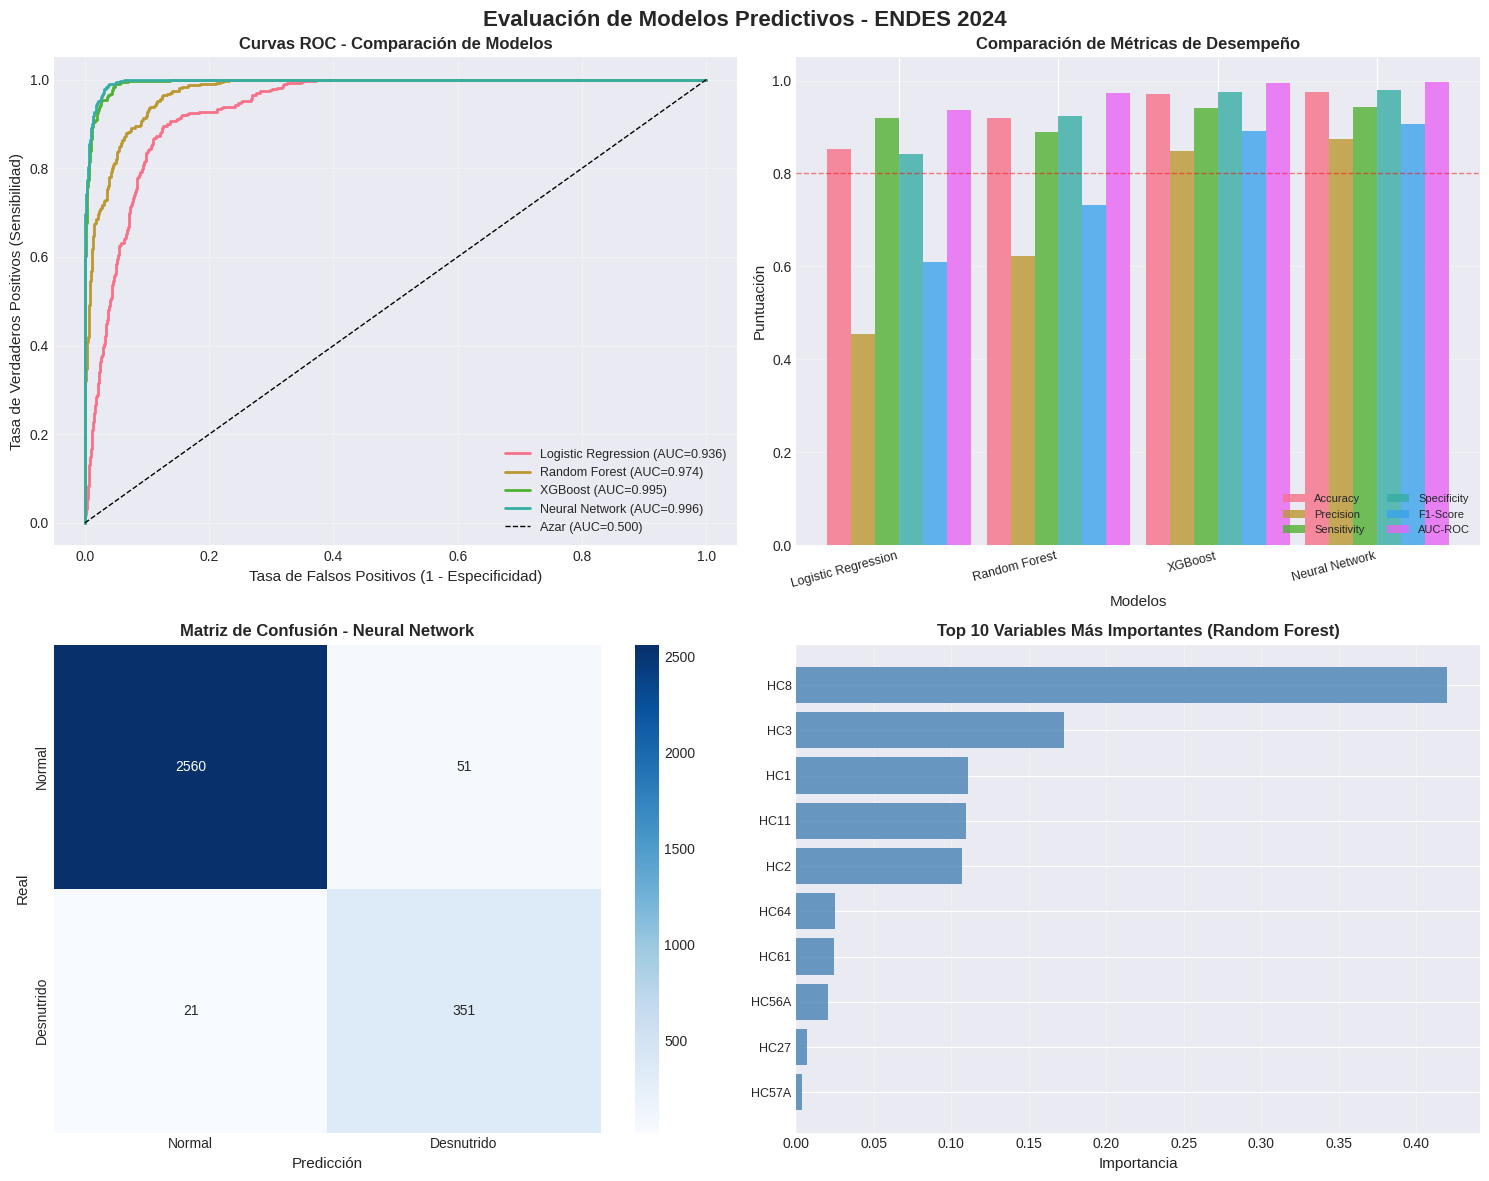

In [25]:
# ============================================================================
# 10. VISUALIZACIONES
# ============================================================================

print("\n📊 GENERANDO VISUALIZACIONES...")

# 10.1 Curvas ROC
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Evaluación de Modelos Predictivos - ENDES 2024', fontsize=16, fontweight='bold')

# Subplot 1: Curvas ROC
ax1 = axes[0, 0]
for result in results:
    if result['Model'] == 'Neural Network':
        y_pred_proba = models['Neural Network'].predict(X_test, verbose=0).flatten()
    else:
        y_pred_proba = result['y_pred_proba']

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = result['AUC-ROC']
    ax1.plot(fpr, tpr, label=f"{result['Model']} (AUC={auc:.3f})", linewidth=2)

ax1.plot([0, 1], [0, 1], 'k--', label='Azar (AUC=0.500)', linewidth=1)
ax1.set_xlabel('Tasa de Falsos Positivos (1 - Especificidad)', fontsize=11)
ax1.set_ylabel('Tasa de Verdaderos Positivos (Sensibilidad)', fontsize=11)
ax1.set_title('Curvas ROC - Comparación de Modelos', fontsize=12, fontweight='bold')
ax1.legend(loc='lower right', fontsize=9)
ax1.grid(True, alpha=0.3)

# Subplot 2: Comparación de métricas
ax2 = axes[0, 1]
metrics_to_plot = ['Accuracy', 'Precision', 'Sensitivity', 'Specificity', 'F1-Score', 'AUC-ROC']
x_pos = np.arange(len(results_df))
width = 0.15

for i, metric in enumerate(metrics_to_plot):
    offset = width * (i - 2.5)
    ax2.bar(x_pos + offset, results_df[metric], width, label=metric, alpha=0.8)

ax2.set_xlabel('Modelos', fontsize=11)
ax2.set_ylabel('Puntuación', fontsize=11)
ax2.set_title('Comparación de Métricas de Desempeño', fontsize=12, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(results_df['Model'], rotation=15, ha='right', fontsize=9)
ax2.legend(loc='lower right', fontsize=8, ncol=2)
ax2.set_ylim([0, 1.05])
ax2.grid(True, alpha=0.3, axis='y')
ax2.axhline(y=0.8, color='r', linestyle='--', alpha=0.5, linewidth=1)

# Subplot 3: Matriz de confusión del mejor modelo
ax3 = axes[1, 0]
best_result = [r for r in results if r['Model'] == best_model_name][0]
cm = confusion_matrix(y_test, best_result['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3, cbar=True,
            xticklabels=['Normal', 'Desnutrido'],
            yticklabels=['Normal', 'Desnutrido'])
ax3.set_xlabel('Predicción', fontsize=11)
ax3.set_ylabel('Real', fontsize=11)
ax3.set_title(f'Matriz de Confusión - {best_model_name}', fontsize=12, fontweight='bold')

# Subplot 4: Importancia de variables (Random Forest o XGBoost)
ax4 = axes[1, 1]
if 'Random Forest' in models:
    importances = models['Random Forest'].feature_importances_
    indices = np.argsort(importances)[::-1][:10]

    ax4.barh(range(10), importances[indices], color='steelblue', alpha=0.8)
    ax4.set_yticks(range(10))
    ax4.set_yticklabels([features[i] for i in indices], fontsize=9)
    ax4.set_xlabel('Importancia', fontsize=11)
    ax4.set_title('Top 10 Variables Más Importantes (Random Forest)', fontsize=12, fontweight='bold')
    ax4.invert_yaxis()
    ax4.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('resultados_modelo_endes2024.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico guardado: resultados_modelo_endes2024.png")


In [26]:
# ============================================================================
# 11. GUARDAR RESULTADOS
# ============================================================================

print("\n💾 GUARDANDO RESULTADOS...")

# Guardar tabla de resultados
results_df.to_csv('resultados_metricas_modelos.csv', index=False, encoding='utf-8')
print("✓ Archivo guardado: resultados_metricas_modelos.csv")

# Guardar validación cruzada
if len(cv_results_df) > 0:
    cv_results_df.to_csv('resultados_validacion_cruzada.csv', encoding='utf-8')
    print("✓ Archivo guardado: resultados_validacion_cruzada.csv")

# Guardar reporte detallado
with open('reporte_completo_modelos.txt', 'w', encoding='utf-8') as f:
    f.write("="*80 + "\n")
    f.write("REPORTE COMPLETO - MODELO PREDICTIVO DESNUTRICIÓN CRÓNICA INFANTIL\n")
    f.write("ENDES 2024\n")
    f.write("="*80 + "\n\n")

    f.write(f"Registros totales procesados: {len(X_scaled)}\n")
    f.write(f"Prevalencia desnutrición: {prevalencia:.2f}%\n\n")

    f.write("RESULTADOS DE EVALUACIÓN EN TEST SET:\n")
    f.write(results_df.to_string(index=False))
    f.write("\n\n")

    f.write(f"MEJOR MODELO: {best_model_name}\n")
    f.write(f"AUC-ROC: {results_df.loc[results_df['AUC-ROC'].idxmax(), 'AUC-ROC']:.4f}\n\n")

    if len(cv_results_df) > 0:
        f.write("RESULTADOS DE VALIDACIÓN CRUZADA (10-fold):\n")
        f.write(cv_results_df.to_string())

print("✓ Archivo guardado: reporte_completo_modelos.txt")


💾 GUARDANDO RESULTADOS...
✓ Archivo guardado: resultados_metricas_modelos.csv
✓ Archivo guardado: resultados_validacion_cruzada.csv
✓ Archivo guardado: reporte_completo_modelos.txt


In [27]:
# ============================================================================
# 12. RESUMEN FINAL
# ============================================================================

print("\n" + "="*80)
print("✅ PROCESO COMPLETADO EXITOSAMENTE")
print("="*80)

print(f"\n📊 RESUMEN DE RESULTADOS:")
print(f"   • Total registros procesados: {len(X_scaled)}")
print(f"   • Prevalencia desnutrición: {prevalencia:.2f}%")
print(f"   • Variables predictoras: {len(features)}")
print(f"   • Modelos entrenados: {len(models)}")
print(f"   • Mejor modelo: {best_model_name}")
print(f"   • Mejor AUC-ROC: {results_df['AUC-ROC'].max():.4f}")

print(f"\n📁 ARCHIVOS GENERADOS:")
print(f"   ✓ resultados_modelo_endes2024.png")
print(f"   ✓ resultados_metricas_modelos.csv")
print(f"   ✓ resultados_validacion_cruzada.csv")
print(f"   ✓ reporte_completo_modelos.txt")

print("\n" + "="*80)
print("Análisis completado. Revise los archivos generados para resultados detallados.")
print("="*80)


✅ PROCESO COMPLETADO EXITOSAMENTE

📊 RESUMEN DE RESULTADOS:
   • Total registros procesados: 19883
   • Prevalencia desnutrición: 12.47%
   • Variables predictoras: 10
   • Modelos entrenados: 4
   • Mejor modelo: Neural Network
   • Mejor AUC-ROC: 0.9963

📁 ARCHIVOS GENERADOS:
   ✓ resultados_modelo_endes2024.png
   ✓ resultados_metricas_modelos.csv
   ✓ resultados_validacion_cruzada.csv
   ✓ reporte_completo_modelos.txt

Análisis completado. Revise los archivos generados para resultados detallados.
